# ECRQ Tables and Graphs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.iolib.summary2 import summary_col
from scipy import stats

In [2]:
# Read only total_tract_population column from acs_data.csv
density_pop = pd.read_csv(
    "../data/acs_data_all.csv",
    usecols=["tract", "density"],
    dtype={"density": np.float32, "tract": str},
)
density_pop.columns

Index(['tract', 'density'], dtype='object')

In [3]:
shares_pop = pd.read_csv(
    "../data/tract_population_shares.csv",
    usecols=[
        "state",
        "county",
        "tract",
        "Share of White Population",
        "Share of Black Population",
        "Share of American Indian and Alaska Native Population",
        "Share of Asian Population",
        "Share of Other Race Population",
        "Share of Hispanic or Latino Population",
    ],
    dtype={
        "state": str,
        "county": str,
        "tract": str,
        "Share of White Population": np.float32,
        "Share of Black Population": np.float32,
        "Share of American Indian and Alaska Native Population": np.float32,
        "Share of Asian Population": np.float32,
        "Share of Other Race Population": np.float32,
        "Share of Hispanic or Latino Population": np.float32,
    },
)
shares_pop.columns

Index(['state', 'county', 'tract', 'Share of White Population',
       'Share of Black Population',
       'Share of American Indian and Alaska Native Population',
       'Share of Asian Population', 'Share of Other Race Population',
       'Share of Hispanic or Latino Population'],
      dtype='object')

In [4]:
# Load the data
dtype_dict = {
    "white_adj_supply_any_avg_tract": np.float32,
    "white_adj_supply_hr_avg_tract": np.float32,
    "white_totcost_any_avg_tract": np.float32,
    "black_adj_supply_any_avg_tract": np.float32,
    "black_adj_supply_hr_avg_tract": np.float32,
    "black_totcost_any_avg_tract": np.float32,
    "am_indian_alaska_native_adj_supply_any_avg_tract": np.float32,
    "am_indian_alaska_native_adj_supply_hr_avg_tract": np.float32,
    "am_indian_alaska_native_totcost_any_avg_tract": np.float32,
    "asian_supply_adj_supply_any_tract": np.float32,
    "asian_adj_supply_hr_avg_tract": np.float32,
    "asian_totcost_any_avg_tract": np.float32,
    "other_race_adj_supply_any_avg_tract": np.float32,
    "other_race_adj_supply_hr_avg_tract": np.float32,
    "other_race_totcost_any_avg_tract": np.float32,
    "hispanic_latino_adj_supply_any_avg_tract": np.float32,
    "hispanic_latino_adj_supply_hr_avg_tract": np.float32,
    "hispanic_latino_totcost_any_avg_tract": np.float32,
    "state": str,
    "county": str,
    "tract": str,
    "median_household_income": np.float32,
    "gini_index": np.float32,
    "educational_attainment": np.float32,
    "employment_status": np.float32,
    "housing_tenure": np.float32,
    "poverty_status": np.float32,
    "commute_time": np.float32,
    "without_health_insurance": np.float32,
    "labor_force_status": np.float32,
    "total_population_25_years_and_over": np.float32,
    "white": np.float32,
    "black": np.float32,
    "am_indian_alaska_native": np.float32,
    "asian": np.float32,
    "native_hawaiian_pacific_islander": np.float32,
    "other_race": np.float32,
    "two_or_more_races": np.float32,
    "hispanic_latino": np.float32,
    "total_tract_population": np.int32,
}


data = pd.read_csv(
    "../data/acs_data.csv", dtype=dtype_dict
)  # Replace with the path to your data file

# Merge density_pop to data
data = data.merge(density_pop, how="left", on="tract", validate="1:1")

# Scale median_household_income by 10,000
data["median_household_income"] = data["median_household_income"] / 10000

# Scale density by 10,000
data["density"] = data["density"] / 10000

# Rename the variables
data.rename(
    columns={
        "white_adj_supply_any_avg_tract": "White any",
        "white_adj_supply_hr_avg_tract": "White high rated",
        "white_totcost_any_avg_tract": "White total cost",
        "black_adj_supply_any_avg_tract": "Black any",
        "black_adj_supply_hr_avg_tract": "Black high rated",
        "black_totcost_any_avg_tract": "Black total cost",
        "am_indian_alaska_native_adj_supply_any_avg_tract": "American Indian Alaska Native any",
        "am_indian_alaska_native_adj_supply_hr_avg_tract": "American Indian Alaska Native high rated",
        "am_indian_alaska_native_totcost_any_avg_tract": "American Indian Alaska Native total cost",
        "asian_adj_supply_any_avg_tract": "Asian any",
        "asian_adj_supply_hr_avg_tract": "Asian high rated",
        "asian_totcost_any_avg_tract": "Asian total cost",
        "other_race_adj_supply_any_avg_tract": "Other race any",
        "other_race_adj_supply_hr_avg_tract": "Other race high rated",
        "other_race_totcost_any_avg_tract": "Other race total cost",
        "hispanic_latino_adj_supply_any_avg_tract": "Hispanic Latino any",
        "hispanic_latino_adj_supply_hr_avg_tract": "Hispanic Latino high rated",
        "hispanic_latino_totcost_any_avg_tract": "Hispanic Latino total cost",
        "median_household_income": "Median Household Income",
        "gini_index": "Gini Index",
        "educational_attainment": "Educational Attainment",
        "employment_status": "Employment Status",
        "housing_tenure": "Housing Tenure",
        "poverty_status": "Poverty Status",
        "commute_time": "Commute Time",
        "without_health_insurance": "Without Health Insurance",
        "labor_force_status": "Labor Force Status",
        "total_population_25_years_and_over": "Total Population 25 Years and Over",
        "density": "Population Density",
    },
    inplace=True,
)

# calculate state population
state_population = data.groupby("state")["total_tract_population"].transform("sum")

# create tract_weight
data["tract_weight"] = data["total_tract_population"] / state_population

In [5]:
data["tract"].head()

0    27001770100
1    27001770200
2    27001770300
3    27001770400
4    27001790501
Name: tract, dtype: object

### Read and merge new race population shares
- Race shares are constructed using tract race population divided by state total population

In [6]:
race_shares = pd.read_csv(
    "../data/acs_data_all.csv",
    usecols=[
        "tract",
        "white_share_state",
        "black_share_state",
        "am_indian_alaska_native_share_state",
        "asian_share_state",
        "other_race_share_state",
        "hispanic_latino_share_state",
    ],
    dtype={
        "tract": str,
        "white_share_state": np.float32,
        "black_share_state": np.float32,
        "am_indian_alaska_native_share_state": np.float32,
        "asian_share_state": np.float32,
        "other_race_share_state": np.float32,
        "hispanic_latino_share_state": np.float32,
    },
)
race_shares.head()

,tract,white_share_state,black_share_state,am_indian_alaska_native_share_state,asian_share_state,other_race_share_state,hispanic_latino_share_state
0,27001770100,0.000377,2.696204e-06,0.000008,3.055698e-06,0.000004,0.000008
1,27001770200,0.000369,1.258228e-06,0.000017,7.189876e-07,0.000019,0.000004
2,27001770300,0.000584,5.032914e-06,0.000007,2.336710e-06,0.000015,0.000013
3,27001770400,0.000491,2.696204e-06,0.000025,0.000000e+00,0.000008,0.000007
4,27001790501,0.000335,7.189876e-07,0.000000,2.516457e-06,0.000003,0.000002


In [7]:
# Merge data and race_shares using census tract
data = data.merge(shares_pop, on=["state", "county", "tract"], how="left")

# Rename race_shares columns
names_race_shares = {
    "Share of White Population": "Share of White population",
    "Share of Black Population": "Share of Black population",
    "Share of American Indian and Alaska Native Population": "Share of American Indian or Alaska Native population",
    "Share of Asian Population": "Share of Asian population",
    "Share of Other Race Population": "Share of Other Race population",
    "Share of Hispanic or Latino Population": "Share of Hispanic or Latino population",
}

share_variables = list(names_race_shares.values())

data.rename(columns=names_race_shares, inplace=True)

## Summary Statistics

In [8]:
variables = {
    "White any": "white",
    "White high rated": "white",
    "White total cost": "white",
    "Black any": "black",
    "Black high rated": "black",
    "Black total cost": "black",
    "American Indian Alaska Native any": "am_indian_alaska_native",
    "American Indian Alaska Native high rated": "am_indian_alaska_native",
    "American Indian Alaska Native total cost": "am_indian_alaska_native",
    "Asian any": "asian",
    "Asian high rated": "asian",
    "Asian total cost": "asian",
    "Other race any": "other_race",
    "Other race high rated": "other_race",
    "Other race total cost": "other_race",
    "Hispanic Latino any": "hispanic_latino",
    "Hispanic Latino high rated": "hispanic_latino",
    "Hispanic Latino total cost": "hispanic_latino",
    "Median Household Income": "median_household_income",
    "Gini Index": "gini_index",
    "Educational Attainment": "educational_attainment",
    "Employment Status": "employment_status",
    "Housing Tenure": "housing_tenure",
    "Poverty Status": "poverty_status",
    "Commute Time": "commute_time",
    "Without Health Insurance": "without_health_insurance",
    "Population Density": "density",
}

racial_groups = list(variables.keys())[:18]
racial_weights = list(variables.values())[:18]
other_covariates = list(variables.keys())[18:] + share_variables

summary_statistics = {}

# Calculate weighted averages and standard deviations for racial groups
for group, weight in zip(racial_groups, racial_weights):
    weighted_mean = (data[group] * data[weight]).sum()
    weighted_std = np.sqrt((data[weight] * (data[group] - weighted_mean) ** 2).sum())
    summary_statistics[group] = {"mean": weighted_mean, "std": weighted_std}

# Calculate weighted averages and standard deviations for other covariates using 'tract_weight' as weight
for covariate in other_covariates:
    weighted_mean = (data[covariate] * data["tract_weight"]).sum() / data[
        "tract_weight"
    ].sum()
    weighted_std = np.sqrt(
        (data["tract_weight"] * (data[covariate] - weighted_mean) ** 2).sum()
        / data["tract_weight"].sum()
    )
    summary_statistics[covariate] = {"mean": weighted_mean, "std": weighted_std}

# Convert the dictionary to a DataFrame
summary_statistics_df = pd.DataFrame(summary_statistics).T

# Format the summary statistics table
summary_statistics_df = summary_statistics_df.applymap("{:.2f}".format)
summary_statistics_df["std"] = "(" + summary_statistics_df["std"] + ")"
summary_statistics_df.rename(
    columns={"mean": "Mean", "std": "Std Deviation"}, inplace=True
)

print(summary_statistics_df)

                                                      Mean Std Deviation
White any                                             0.57        (0.29)
White high rated                                      0.13        (0.12)
White total cost                                    179.09       (67.47)
Black any                                             0.59        (0.24)
Black high rated                                      0.20        (0.11)
Black total cost                                    214.62       (52.11)
American Indian Alaska Native any                     0.59        (0.37)
American Indian Alaska Native high rated              0.11        (0.14)
American Indian Alaska Native total cost            129.34       (72.23)
Asian any                                             0.00        (0.02)
Asian high rated                                      0.00        (0.01)
Asian total cost                                      0.35        (9.06)
Other race any                                     

## CDF Plots

In [9]:
def weighted_percentile(data, weights, percentile):
    """
    Calculate the weighted percentile of a 1D numpy array.
    """
    # Sort the data
    idx_sorted = np.argsort(data)
    sorted_data = data[idx_sorted]
    sorted_weights = weights[idx_sorted]

    # Calculate the cumulative sum of weights
    sn = np.cumsum(sorted_weights)

    # Calculate the percentile
    p = percentile / 100.0
    target = p * np.sum(weights)
    return np.interp(target, sn, sorted_data)

In [10]:
def calculate_percentiles(data, race_variables, weight_map):
    # Initialize an empty DataFrame to store the percentiles
    percentiles = pd.DataFrame()

    # Calculate the percentiles for each group
    for var in race_variables:
        # Get the weights for this variable
        weights = data[weight_map[var]]

        # Calculate the weighted percentiles
        percentiles[var] = [
            weighted_percentile(data[var].values, weights.values, i)
            for i in range(5, 100, 5)
        ]

    # Transpose the DataFrame for a better layout
    percentiles = percentiles.transpose()

    # Rename the index and columns for clarity
    percentiles.index.name = "Race"
    percentiles.columns = [f"{i}th Percentile" for i in range(5, 100, 5)]

    return percentiles

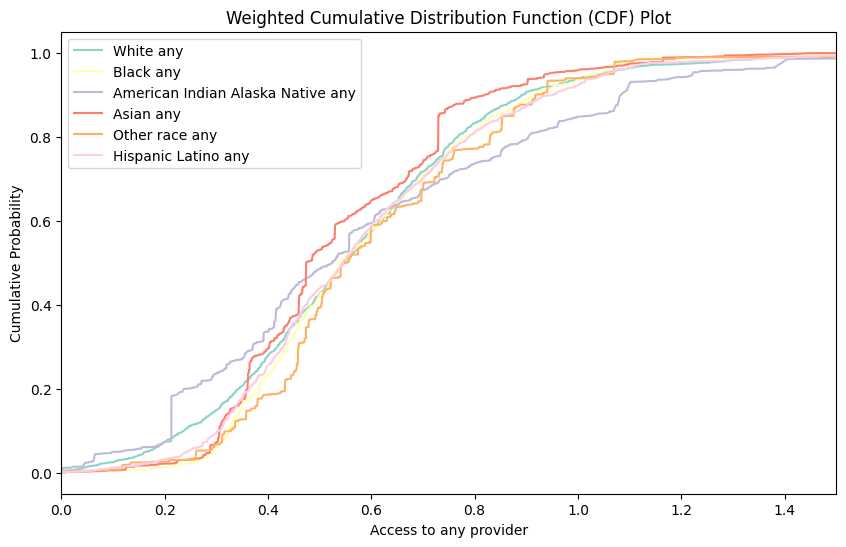

In [11]:
# CDF plot
race_variables1 = [
    "White any",
    "Black any",
    "American Indian Alaska Native any",
    "Asian any",
    "Other race any",
    "Hispanic Latino any",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map1 = {
    "White any": "white",
    "Black any": "black",
    "American Indian Alaska Native any": "am_indian_alaska_native",
    "Asian any": "asian",
    "Other race any": "other_race",
    "Hispanic Latino any": "hispanic_latino",
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables1, colors):
    # Get the weights for this variable
    weights = data[weight_map1[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot")
ax.set_xlabel("Access to any provider")
ax.set_ylabel("Cumulative Probability")
ax.legend(loc="upper left")

# Set x-axis limit
ax.set_xlim(0, 1.5)

plt.show()

In [12]:
percentiles1 = calculate_percentiles(data, race_variables1, weight_map1)
print(percentiles1)

                                   5th Percentile  10th Percentile  \
Race                                                                 
White any                                0.165468         0.237132   
Black any                                0.296085         0.324263   
American Indian Alaska Native any        0.111673         0.212900   
Asian any                                0.287893         0.306064   
Other race any                           0.261041         0.328390   
Hispanic Latino any                      0.245376         0.306339   

                                   15th Percentile  20th Percentile  \
Race                                                                  
White any                                 0.302368         0.343670   
Black any                                 0.348415         0.383209   
American Indian Alaska Native any         0.213072         0.241906   
Asian any                                 0.327036         0.360379   
Other race an

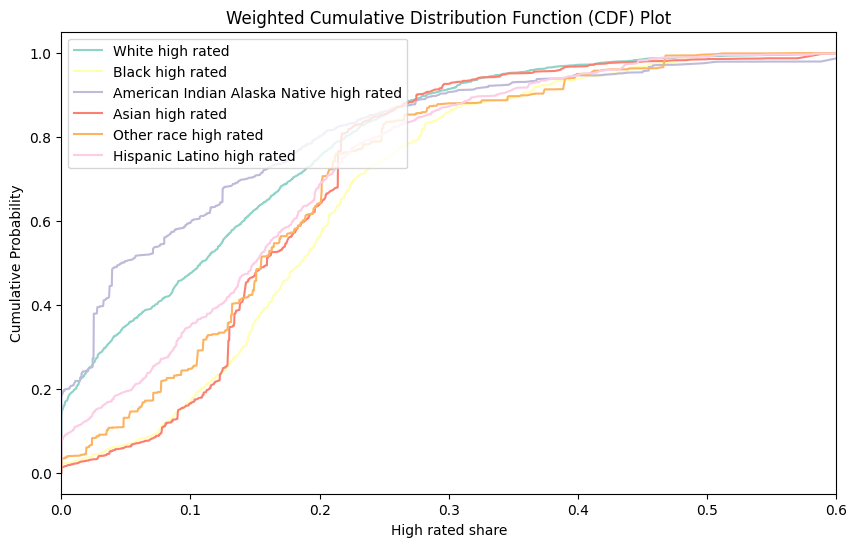

In [13]:
# CDF plot
race_variables2 = [
    "White high rated",
    "Black high rated",
    "American Indian Alaska Native high rated",
    "Asian high rated",
    "Other race high rated",
    "Hispanic Latino high rated",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map2 = {
    "White high rated": "white",
    "Black high rated": "black",
    "American Indian Alaska Native high rated": "am_indian_alaska_native",
    "Asian high rated": "asian",
    "Other race high rated": "other_race",
    "Hispanic Latino high rated": "hispanic_latino",
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables2, colors):
    # Get the weights for this variable
    weights = data[weight_map2[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot")
ax.set_xlabel("High rated share")
ax.set_ylabel("Cumulative Probability")
ax.legend(loc="upper left")

# Set x-axis limit
ax.set_xlim(0, 0.6)

plt.show()

In [14]:
percentiles2 = calculate_percentiles(data, race_variables2, weight_map2)
print(percentiles2)

                                          5th Percentile  10th Percentile  \
Race                                                                        
White high rated                            0.000000e+00     5.787320e-09   
Black high rated                            3.283242e-02     7.559999e-02   
American Indian Alaska Native high rated    0.000000e+00     0.000000e+00   
Asian high rated                            3.739077e-02     7.775709e-02   
Other race high rated                       1.922812e-02     3.521676e-02   
Hispanic Latino high rated                  2.204224e-13     8.508451e-03   

                                          15th Percentile  20th Percentile  \
Race                                                                         
White high rated                             1.060920e-03         0.011304   
Black high rated                             9.218419e-02         0.107929   
American Indian Alaska Native high rated     1.701396e-10         0.006

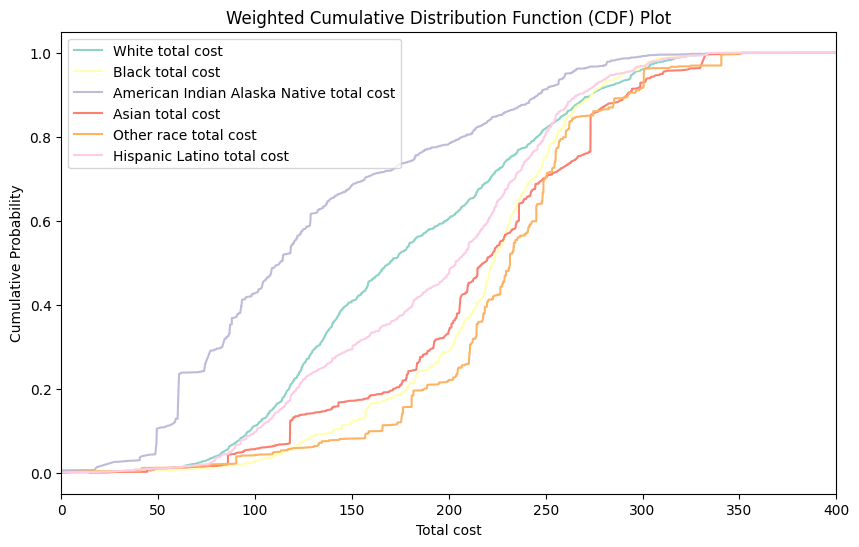

In [15]:
# CDF plot
race_variables3 = [
    "White total cost",
    "Black total cost",
    "American Indian Alaska Native total cost",
    "Asian total cost",
    "Other race total cost",
    "Hispanic Latino total cost",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map3 = {
    "White total cost": "white",
    "Black total cost": "black",
    "American Indian Alaska Native total cost": "am_indian_alaska_native",
    "Asian total cost": "asian",
    "Other race total cost": "other_race",
    "Hispanic Latino total cost": "hispanic_latino",
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables3, colors):
    # Get the weights for this variable
    weights = data[weight_map3[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot")
ax.set_xlabel("Total cost")
ax.set_ylabel("Cumulative Probability")
ax.legend(loc="upper left")

# Set x-axis limit
ax.set_xlim(0, 400)

plt.show()

In [16]:
percentiles3 = calculate_percentiles(data, race_variables3, weight_map3)
print(percentiles3)

                                          5th Percentile  10th Percentile  \
Race                                                                        
White total cost                               83.806006        97.330031   
Black total cost                              114.901900       140.592581   
American Indian Alaska Native total cost       48.659141        49.316695   
Asian total cost                               93.967815       118.078080   
Other race total cost                         113.003000       165.660053   
Hispanic Latino total cost                     87.702676       100.844787   

                                          15th Percentile  20th Percentile  \
Race                                                                         
White total cost                               108.788998       117.603584   
Black total cost                               157.507791       178.411040   
American Indian Alaska Native total cost        60.186690        60.527

## Matrix of Differences

In [17]:
# Read the CSV file into a DataFrame
matrix_data = pd.read_csv("../data/matrix_of_differences.csv", index_col=0)

# Convert 'state', 'county', and 'tract' to strings
matrix_data["state"] = matrix_data["state"].astype(str)
matrix_data["county"] = matrix_data["county"].astype(str)
matrix_data["tract"] = matrix_data["tract"].astype(str)

# Convert all other columns to numeric
for column in matrix_data.columns:
    if column not in ["state", "county", "tract"]:
        matrix_data[column] = pd.to_numeric(matrix_data[column], errors="coerce")

# Display the first few rows to check the result
matrix_data.head()

,Share of White Population,Share of Black Population,Share of American Indian and Alaska Native Population,Share of Asian Population,Share of Other Race Population,Share of Hispanic or Latino Population,state,county,tract
0,2140,583,0,367,74,930,27,27053,27053025401
1,2480,55,1,50,98,0,27,27053,27053025805
2,5636,1,0,1139,372,184,27,27053,27053026018
3,4793,483,0,1237,145,24,27,27053,27053026402
4,4980,122,3,116,38,0,27,27053,27053026404


In [18]:
matrix_data.columns

Index(['Share of White Population', 'Share of Black Population',
       'Share of American Indian and Alaska Native Population',
       'Share of Asian Population', 'Share of Other Race Population',
       'Share of Hispanic or Latino Population', 'state', 'county', 'tract'],
      dtype='object')

In [19]:
# CDF plot
race_variables1 = [
    "White any",
    "Black any",
    "American Indian Alaska Native any",
    "Asian any",
    "Other race any",
    "Hispanic Latino any",
]

weight_map1 = {
    "White any": "Share of White Population",
    "Black any": "Share of Black Population",
    "American Indian Alaska Native any": "Share of American Indian and Alaska Native Population",
    "Asian any": "Share of Asian Population",
    "Other race any": "Share of Other Race Population",
    "Hispanic Latino any": "Share of Hispanic or Latino Population",
}

In [20]:
# List of columns to drop
columns_to_drop = [
    "Share of White Population",
    "Share of Black Population",
    "Share of American Indian and Alaska Native Population",
    "Share of Asian Population",
    "Share of Other Race Population",
    "Share of Hispanic or Latino Population",
]

# Drop only the columns that exist in the data
columns_to_drop_exist = [col for col in columns_to_drop if col in data.columns]
data_dropped_columns = data.drop(columns=columns_to_drop_exist)

# Perform a left merge with matrix_data on the key variables
merged_data = pd.merge(
    data_dropped_columns, matrix_data, how="left", on=["state", "county", "tract"]
)

In [21]:
# Create an empty dataframe for the significance
significance_matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)
# Create an empty dataframe for the matrix of mean differences
matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)
# Create an empty dataframe for the matrix of p-values
pvalue_matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)


def weighted_sample(series, weights):
    return np.repeat(series, weights)


for row_var in race_variables1:
    for col_var in race_variables1:
        if row_var != col_var:
            row_weighted_sample = weighted_sample(
                merged_data[row_var], merged_data[weight_map1[row_var]]
            )
            col_weighted_sample = weighted_sample(
                merged_data[col_var], merged_data[weight_map1[col_var]]
            )

            if np.var(row_weighted_sample) == 0 or np.var(col_weighted_sample) == 0:
                continue

            t_stat, p_value = stats.ttest_ind(row_weighted_sample, col_weighted_sample)

            row_weighted_mean = (
                merged_data[row_var] * merged_data[weight_map1[row_var]]
            ).sum() / merged_data[weight_map1[row_var]].sum()
            col_weighted_mean = (
                merged_data[col_var] * merged_data[weight_map1[col_var]]
            ).sum() / merged_data[weight_map1[col_var]].sum()

            matrix1.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix1.loc[row_var, col_var] = "*" if p_value < 0.05 else ""
            pvalue_matrix1.loc[row_var, col_var] = p_value

In [22]:
matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,-0.018652,-0.021019,0.029188,-0.020932,-0.016151
Black any,0.018652,NaN,-0.002367,0.04784,-0.002281,0.002501
American Indian Alaska Native any,0.021019,0.002367,NaN,0.050207,0.000087,0.004868
Asian any,-0.029188,-0.04784,-0.050207,NaN,-0.05012,-0.045339
Other race any,0.020932,0.002281,-0.000087,0.05012,NaN,0.004781
Hispanic Latino any,0.016151,-0.002501,-0.004868,0.045339,-0.004781,NaN


In [23]:
significance_matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,*,*,*,*,*
Black any,*,NaN,,*,*,*
American Indian Alaska Native any,*,,NaN,*,,*
Asian any,*,*,*,NaN,*,*
Other race any,*,*,,*,NaN,*
Hispanic Latino any,*,*,*,*,*,NaN


In [24]:
pvalue_matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,0.0,0.0,0.0,0.0,0.0
Black any,0.0,NaN,0.055512,0.0,0.004185,0.00008
American Indian Alaska Native any,0.0,0.055512,NaN,0.0,0.956948,0.000348
Asian any,0.0,0.0,0.0,NaN,0.0,0.0
Other race any,0.0,0.004185,0.956948,0.0,NaN,0.0
Hispanic Latino any,0.0,0.00008,0.000348,0.0,0.0,NaN


In [25]:
# CDF plot
race_variables2 = [
    "White high rated",
    "Black high rated",
    "American Indian Alaska Native high rated",
    "Asian high rated",
    "Other race high rated",
    "Hispanic Latino high rated",
]

weight_map2 = {
    "White high rated": "Share of White Population",
    "Black high rated": "Share of Black Population",
    "American Indian Alaska Native high rated": "Share of American Indian and Alaska Native Population",
    "Asian high rated": "Share of Asian Population",
    "Other race high rated": "Share of Other Race Population",
    "Hispanic Latino high rated": "Share of Hispanic or Latino Population",
}

In [26]:
# Create an empty dataframe for the significance
significance_matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)
# Create an empty dataframe for the matrix of mean differences
matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)
# Create an empty dataframe for the matrix of p-values
pvalue_matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)

for row_var in race_variables2:
    for col_var in race_variables2:
        if row_var != col_var:
            row_weighted_sample = weighted_sample(
                merged_data[row_var], merged_data[weight_map2[row_var]]
            )
            col_weighted_sample = weighted_sample(
                merged_data[col_var], merged_data[weight_map2[col_var]]
            )

            if np.var(row_weighted_sample) == 0 or np.var(col_weighted_sample) == 0:
                continue

            t_stat, p_value = stats.ttest_ind(row_weighted_sample, col_weighted_sample)

            row_weighted_mean = (
                merged_data[row_var] * merged_data[weight_map2[row_var]]
            ).sum() / merged_data[weight_map2[row_var]].sum()
            col_weighted_mean = (
                merged_data[col_var] * merged_data[weight_map2[col_var]]
            ).sum() / merged_data[weight_map2[col_var]].sum()

            matrix2.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix2.loc[row_var, col_var] = "*" if p_value < 0.05 else ""
            pvalue_matrix2.loc[row_var, col_var] = p_value


In [27]:
matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,-0.069712,0.013353,-0.049994,-0.033577,-0.034244
Black high rated,0.069712,NaN,0.083065,0.019718,0.036135,0.035469
American Indian Alaska Native high rated,-0.013353,-0.083065,NaN,-0.063347,-0.04693,-0.047597
Asian high rated,0.049994,-0.019718,0.063347,NaN,0.016417,0.015751
Other race high rated,0.033577,-0.036135,0.04693,-0.016417,NaN,-0.000666
Hispanic Latino high rated,0.034244,-0.035469,0.047597,-0.015751,0.000666,NaN


In [28]:
significance_matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,*,*,*,*,*
Black high rated,*,NaN,*,*,*,*
American Indian Alaska Native high rated,*,*,NaN,*,*,*
Asian high rated,*,*,*,NaN,*,*
Other race high rated,*,*,*,*,NaN,
Hispanic Latino high rated,*,*,*,*,,NaN


In [29]:
pvalue_matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,0.0,0.0,0.0,0.0,0.0
Black high rated,0.0,NaN,0.0,0.0,0.0,0.0
American Indian Alaska Native high rated,0.0,0.0,NaN,0.0,0.0,0.0
Asian high rated,0.0,0.0,0.0,NaN,0.0,0.0
Other race high rated,0.0,0.0,0.0,0.0,NaN,0.078448
Hispanic Latino high rated,0.0,0.0,0.0,0.0,0.078448,NaN


In [30]:
# CDF plot
race_variables3 = [
    "White total cost",
    "Black total cost",
    "American Indian Alaska Native total cost",
    "Asian total cost",
    "Other race total cost",
    "Hispanic Latino total cost",
]

weight_map3 = {
    "White total cost": "Share of White Population",
    "Black total cost": "Share of Black Population",
    "American Indian Alaska Native total cost": "Share of American Indian and Alaska Native Population",
    "Asian total cost": "Share of Asian Population",
    "Other race total cost": "Share of Other Race Population",
    "Hispanic Latino total cost": "Share of Hispanic or Latino Population",
}

In [31]:
# Create an empty dataframe for the significance
significance_matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)
# Create an empty dataframe for the matrix of mean differences
matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)
# Create an empty dataframe for the matrix of p-values
pvalue_matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)

for row_var in race_variables3:
    for col_var in race_variables3:
        if row_var != col_var:
            row_weighted_sample = weighted_sample(
                merged_data[row_var], merged_data[weight_map3[row_var]]
            )
            col_weighted_sample = weighted_sample(
                merged_data[col_var], merged_data[weight_map3[col_var]]
            )

            if np.var(row_weighted_sample) == 0 or np.var(col_weighted_sample) == 0:
                continue

            t_stat, p_value = stats.ttest_ind(row_weighted_sample, col_weighted_sample)

            row_weighted_mean = (
                merged_data[row_var] * merged_data[weight_map3[row_var]]
            ).sum() / merged_data[weight_map3[row_var]].sum()
            col_weighted_mean = (
                merged_data[col_var] * merged_data[weight_map3[col_var]]
            ).sum() / merged_data[weight_map3[col_var]].sum()

            matrix3.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix3.loc[row_var, col_var] = "*" if p_value < 0.05 else ""
            pvalue_matrix3.loc[row_var, col_var] = p_value

In [32]:
matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,-36.129424,49.224353,-36.272139,-19.558647,-12.285305
Black total cost,36.129424,NaN,85.353778,-0.142715,16.570777,23.844119
American Indian Alaska Native total cost,-49.224353,-85.353778,NaN,-85.496492,-68.783,-61.509658
Asian total cost,36.272139,0.142715,85.496492,NaN,16.713492,23.986834
Other race total cost,19.558647,-16.570777,68.783,-16.713492,NaN,7.273342
Hispanic Latino total cost,12.285305,-23.844119,61.509658,-23.986834,-7.273342,NaN


In [33]:
significance_matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,*,*,*,*,*
Black total cost,*,NaN,*,,*,*
American Indian Alaska Native total cost,*,*,NaN,*,*,*
Asian total cost,*,,*,NaN,*,*
Other race total cost,*,*,*,*,NaN,*
Hispanic Latino total cost,*,*,*,*,*,NaN


In [34]:
pvalue_matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,0.0,0.0,0.0,0.0,0.0
Black total cost,0.0,NaN,0.0,0.319215,0.0,0.0
American Indian Alaska Native total cost,0.0,0.0,NaN,0.0,0.0,0.0
Asian total cost,0.0,0.319215,0.0,NaN,0.0,0.0
Other race total cost,0.0,0.0,0.0,0.0,NaN,0.0
Hispanic Latino total cost,0.0,0.0,0.0,0.0,0.0,NaN


## Matrix of Differences with color

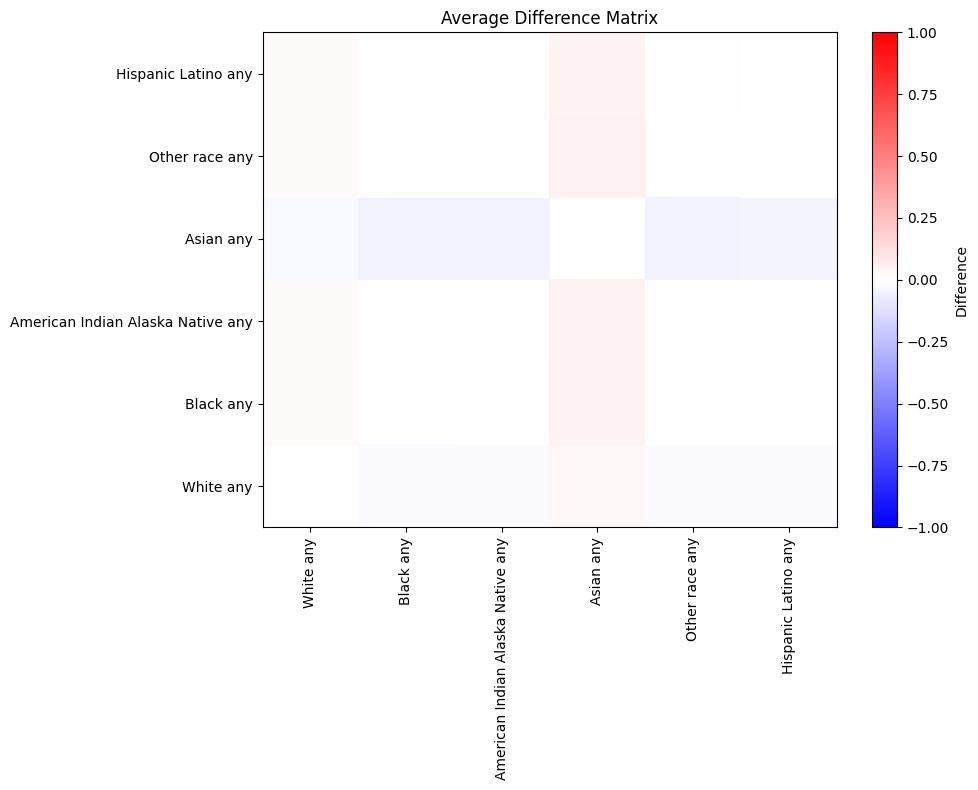

In [35]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix1 = matrix1.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix1, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix1.columns), 1),
    matrix1.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix1.index), 1), matrix1.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

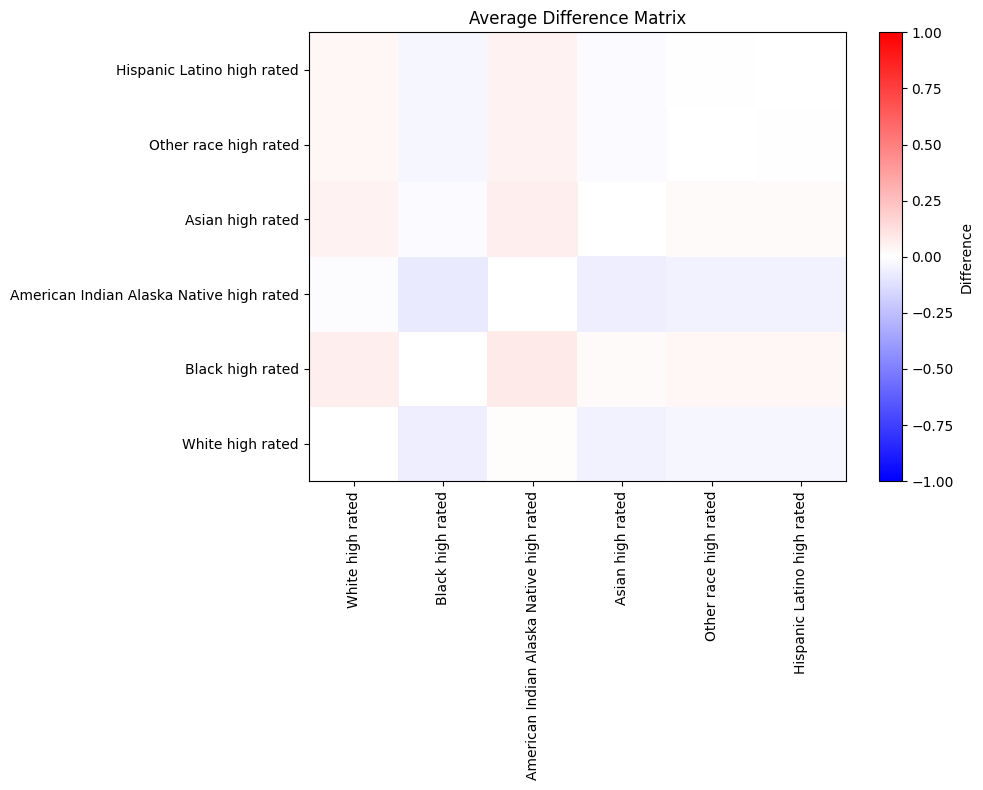

In [36]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix2 = matrix2.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix2, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix2.columns), 1),
    matrix2.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix2.index), 1), matrix2.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

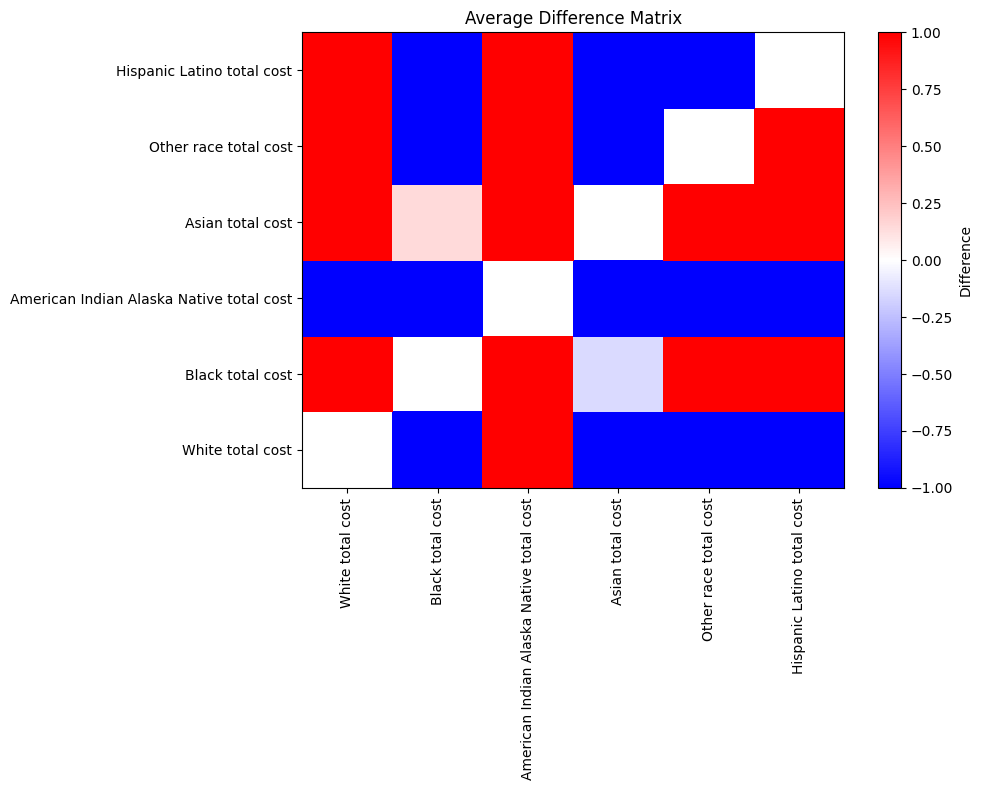

In [37]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix3 = matrix3.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix3, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix3.columns), 1),
    matrix3.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix3.index), 1), matrix3.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()